In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az


In [22]:
# Read CSV files
data_ump1 = pd.read_csv("ISEN_427_final_project_umpire_1.csv")
data_ump2 = pd.read_csv("ISEN_427_final_project_umpire_2.csv")
data_ump3 = pd.read_csv("ISEN_427_final_project_umpire_3.csv")

# Select columns of interest
columns_of_interest = ['release_speed', 'zone', 'stand', 'p_throws', 'type', 'vy0','on_3b','pitcher_walkRate','batter_onBasePercentage', 'pfx_x', 'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate', 'delta_run_exp', 'leverage_index']
df_u1 = data_ump1[columns_of_interest]
df_u2 = data_ump2[columns_of_interest]
df_u3 = data_ump3[columns_of_interest]
model_comp = {}

In [23]:
# Map values in 'p_throws' and 'stand' columns to 0 and 1
df_u1.loc[:, 'p_throws'] = np.where(df_u1['p_throws'] == 'L', 0, 1)
df_u1.loc[:, 'stand'] = np.where(df_u1['stand'] == 'L', 0, 1)

# Calculate umpire mistake
ump_correct_u1 = np.where(((df_u1['zone'] < 10) & (df_u1['type'] == 'B')) | ((df_u1['zone'] > 10) & (df_u1['type'] == 'S')), 0, 1)

# Add calculated columns
df_u1.loc[:,'ump_correct'] = ump_correct_u1

# Calculate distance from strike zone
df_u1.loc[:,'x_dis'] = np.where(df_u1['plate_x'] > 0, abs(0.8 - df_u1['plate_x']), abs(-0.8 - df_u1['plate_x']))

df_u1.loc[:,'z_dis'] = np.where(df_u1['plate_z'] < (df_u1['sz_bot'] + df_u1['sz_top']) / 2, 
                                abs(df_u1['sz_bot'] - df_u1['plate_z']), abs(df_u1['sz_top'] - df_u1['plate_z']))

# Assign inzone values
df_u1.loc[:,'inzone'] = np.where(df_u1['zone'] < 10, 1, 0)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_14308\167000977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_u1.loc[:,'ump_correct'] = ump_correct_u1
C:\Users\jaspe\AppData\Local\Temp\ipykernel_14308\167000977.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_u1.loc[:,'x_dis'] = np.where(df_u1['plate_x'] > 0, abs(0.8 - df_u1['plate_x']), abs(-0.8 - df_u1['plate_x']))
C:\Users\jaspe\AppData\Local\Temp\ipykernel_14308\167000977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [4]:
model_comp = {}
y_obs = df_u1['ump_correct'].values
X = df_u1[['plate_x', 'plate_z']].values

with pm.Model() as model_A:
    # Priors
    
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)
    beta_2 = pm.Normal("beta_2", 0, 1)
    
    mu = pm.Deterministic("mu", beta_0 + beta_1 * X[:, 0] + beta_2 * X[:,1])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #liklihood
    y = pm.Bernoulli('y', p=theta, observed=y_obs)
    
    # Posterior
    step = pm.NUTS()
    inf_regression_A = pm.sample(step=step, chains=4, cores=4, idata_kwargs={"log_likelihood":True})
    inf_regression_A.extend(pm.sample_posterior_predictive(inf_regression_A))
    model_comp["A"] = inf_regression_A

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 145 seconds.


Sampling: [y]


Output()

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>]], dtype=object)

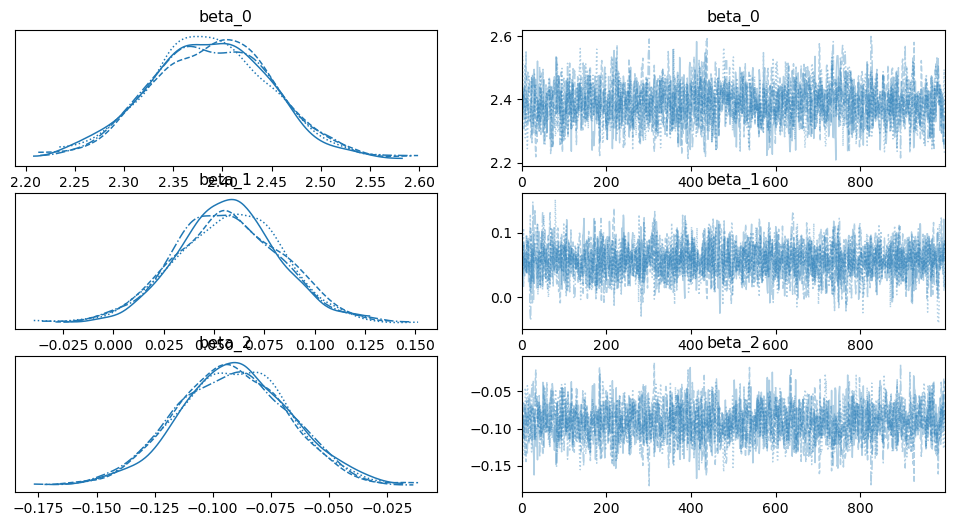

In [5]:
# Analyze the results
az.plot_trace(inf_regression_A, var_names=["beta_0","beta_1","beta_2"])

In [6]:
y_obs = df_u1['ump_correct'].values
X = df_u1[['plate_x', 'plate_z', 'delta_run_exp']].values

with pm.Model() as model_B:
    # Priors
    
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)
    beta_2 = pm.Normal("beta_2", 0, 1)
    beta_3 = pm.Normal("beta_3", 0, 1)
    
    mu = pm.Deterministic("mu", beta_0 + beta_1 * X[:, 0] + beta_2 * X[:,1] + beta_3 * X[:,2])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #liklihood
    y = pm.Bernoulli('y', p=theta, observed=y_obs)
    
    # Posterior
    step = pm.NUTS()
    inf_regression_B = pm.sample(step=step, chains=4, cores=4, idata_kwargs={"log_likelihood":True})
    inf_regression_B.extend(pm.sample_posterior_predictive(inf_regression_B))
    model_comp["B"] = inf_regression_B

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.


Sampling: [y]


Output()

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

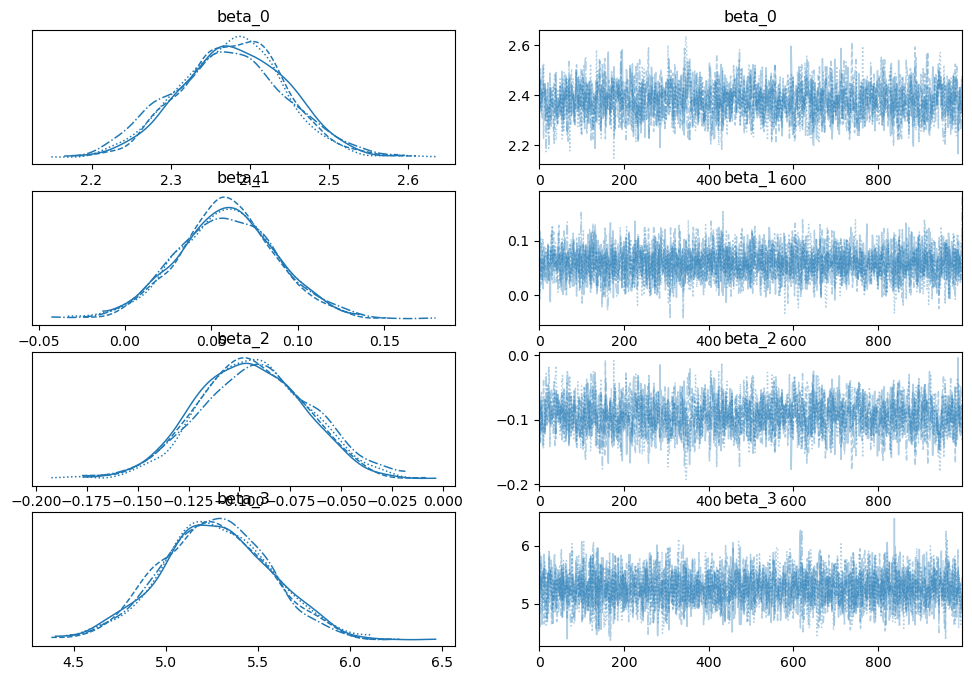

In [7]:
# Analyze the results
az.plot_trace(inf_regression_B, var_names=["beta_0","beta_1","beta_2","beta_3"])

In [8]:
y_obs = df_u1['ump_correct'].values
X = df_u1[['x_dis', 'z_dis']].values

with pm.Model() as model_C:
    # Priors
    
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)
    beta_2 = pm.Normal("beta_2", 0, 1)
    
    
    mu = pm.Deterministic("mu", beta_0 + beta_1 * X[:, 0] + beta_2 * X[:,1])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #liklihood
    y = pm.Bernoulli('y', p=theta, observed=y_obs)
    
    # Posterior
    step = pm.NUTS()
    inf_regression_C = pm.sample(step=step, chains=4, cores=4, idata_kwargs={"log_likelihood":True})
    inf_regression_C.extend(pm.sample_posterior_predictive(inf_regression_C))
    model_comp["C"] = inf_regression_C

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.


Sampling: [y]


Output()

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>]], dtype=object)

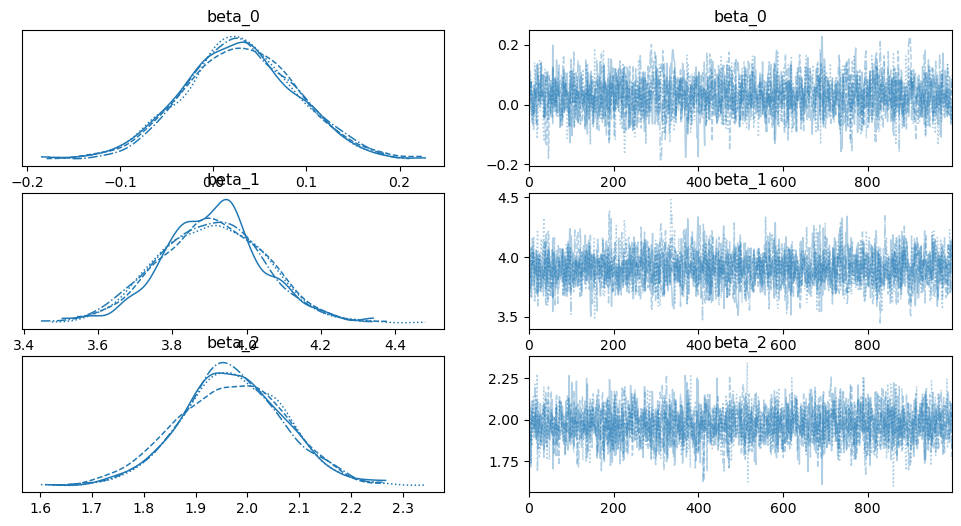

In [9]:
# Analyze the results
az.plot_trace(inf_regression_C, var_names=["beta_0","beta_1","beta_2"])

In [8]:
y_obs = df_u1['ump_correct'].values
X = df_u1[['x_dis', 'z_dis', 'delta_run_exp']].values

with pm.Model() as model_D:
    # Priors
    
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)
    beta_2 = pm.Normal("beta_2", 0, 1)
    beta_3 = pm.Normal("beta_3", 0, 1)
    
    mu = pm.Deterministic("mu", beta_0 + beta_1 * X[:, 0] + beta_2 * X[:,1] + beta_3 * X[:,2])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #liklihood
    y = pm.Bernoulli('y', p=theta, observed=y_obs)
    
    # Posterior
    step = pm.NUTS()
    inf_regression_D = pm.sample(step=step, chains=4, cores=4, idata_kwargs={"log_likelihood":True})
    inf_regression_D.extend(pm.sample_posterior_predictive(inf_regression_D))
    model_comp["D"] = inf_regression_D  

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.


Sampling: [y]


Output()

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

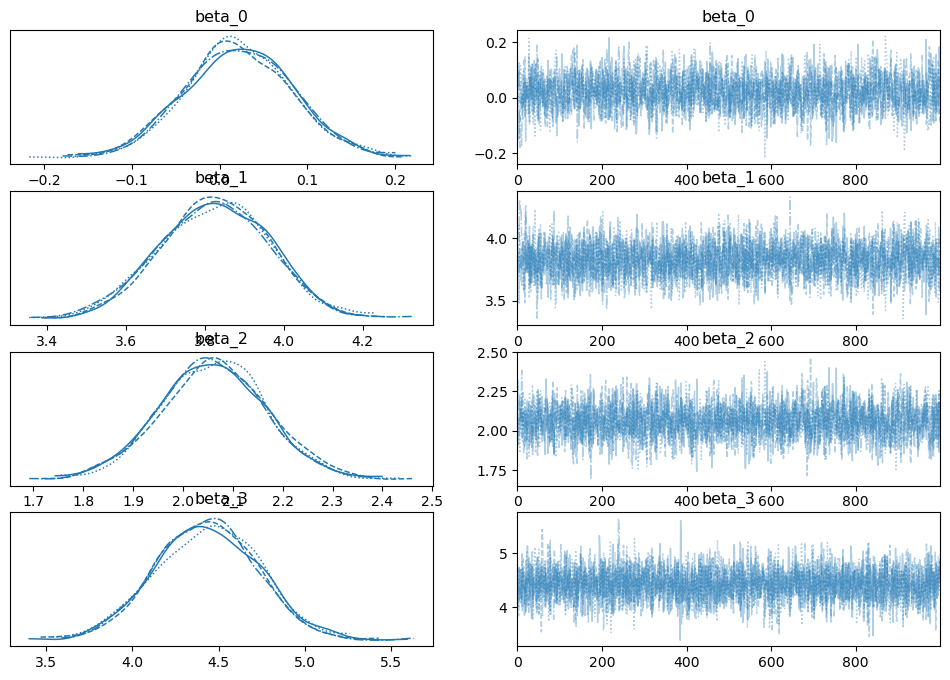

In [24]:
# Analyze the results
az.plot_trace(inf_regression_D, var_names=["beta_0","beta_1","beta_2","beta_3"])

In [37]:
y_obs = df_u1['ump_correct'].values
X = df_u1[['x_dis', 'z_dis', 'pitcher_walkRate']].values

with pm.Model() as model_E:
    # Priors
    
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)
    beta_2 = pm.Normal("beta_2", 0, 1)
    beta_3 = pm.Normal("beta_3", 0, 1)
    
    mu = pm.Deterministic("mu", beta_0 + beta_1 * X[:, 0] + beta_2 * X[:,1] + beta_3 * X[:,2])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    #liklihood
    y = pm.Bernoulli('y', p=theta, observed=y_obs)
    
    # Posterior
    step = pm.NUTS()
    inf_regression_E = pm.sample(step=step, chains=4, cores=4, idata_kwargs={"log_likelihood":True})
    inf_regression_E.extend(pm.sample_posterior_predictive(inf_regression_E))
    model_comp["E"] = inf_regression_E   

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 175 seconds.


Sampling: [y]


Output()

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>]], dtype=object)

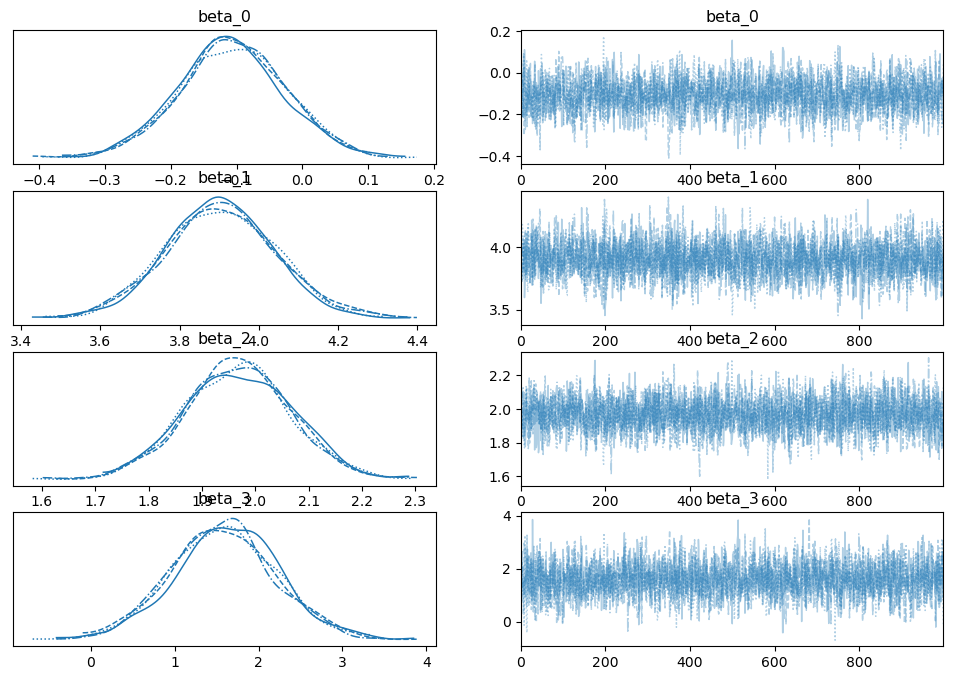

In [13]:
# Analyze the results
az.plot_trace(inf_regression_E, var_names=["beta_0","beta_1","beta_2","beta_3"])

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

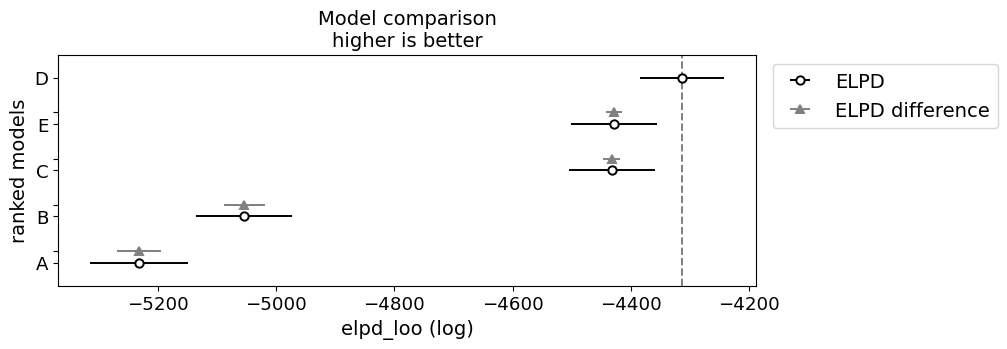

In [14]:
cmp = az.compare(model_comp)
cmp.round(2)
az.plot_compare(cmp, figsize=(9, 3))


In [15]:
cmp.round(2)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
D,0,-4313.63,4.00,0.00,1.0,70.92,0.00,False,log
E,1,-4428.89,3.43,115.25,0.0,72.69,13.89,False,log
C,2,-4432.76,2.95,119.13,0.0,72.76,13.85,False,log
B,3,-5053.41,3.43,739.77,0.0,80.95,34.36,False,log
A,4,-5231.07,2.14,917.44,0.0,83.01,36.98,False,log
